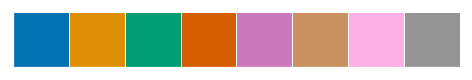

In [48]:
%matplotlib inline
import os
import sys
os.environ['PROJ_LIB']=os.path.join(os.environ['HOME'],'.anaconda3','share','proj')

import astropy.units as units
from brewer2mpl import qualitative, diverging
#import cufflinks as cf
#cf.set_config_file(offline=False, world_readable=True, theme='ggplot')
#import h5py
#from IPython.display import HTML
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import palettable as colortable
from palettable.cartocolors.diverging import Earth_3, Tropic_3_r, Tropic_3
from palettable.colorbrewer.diverging import PuOr_3, RdBu_11
from palettable.colorbrewer.sequential import BuGn_9
from palettable.cmocean.diverging import Balance_9
import pandas as pd
import pytz
import seaborn as sns
import xarray as xr


sns.set()
fontsize = 30
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : fontsize}
mpl.rc('font', **font)
mpl.rcParams['figure.figsize'] = [15.0,10.0]
plt.rcParams['text.usetex']=True
plt.rcParams['text.latex.preamble']=r'\makeatletter \newcommand*{\rom}[1]{\expandafter\@slowromancap\romannumeral #1@} \makeatother'


pal = sns.palplot(sns.color_palette("colorblind", 8))
sns.set_style("whitegrid", {'axes.grid':True, 'ticks':True})
plt.style.use("seaborn-paper")
sns.set_context('paper')
sns.set_palette(pal)
sns.despine()
np.warnings.filterwarnings('ignore')
utc = pytz.UTC
timezone = pytz.timezone('Australia/Darwin')
pal

In [9]:
LS_FORCE = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_large-scale_forcing_WOH.nc')
paper_path = os.path.join(os.environ['HOME'], 'Work', 'Paper', '2018', 'Hector')

In [10]:
data_set = xr.open_dataset(LS_FORCE)

In [11]:
def kindex(dset, temp_name='T', p_name='lev', tsurf_name='T_srf', rh_name = 'r_srf', r_name='r'):
        rh_surf = calc_rh(dset[rh_name]/1000, dset[tsurf_name]+273.15, dset['p_srf_center'])
        Dsurf = calc_dp(dset[tsurf_name], rh_surf)
        rh = calc_rh(dset[r_name]/1000, dset[temp_name], dset[p_name])
        dp = calc_dp(dset[temp_name]-273.15, rh)
        i500 = np.argmin(np.fabs((dset[p_name] - 500).values))
        i850 = np.argmin(np.fabs((dset[p_name] - 850).values))
        i700 = np.argmin(np.fabs((dset[p_name] - 700).values))
        T850 = dset[temp_name][:,i850]-273.15
        T500 = dset[temp_name][:,i500]-273.15
        T700 = dset[temp_name][:,i700]-273.15
        D700 = dp[:,i700]
        D850 = dp[:,i850]
        Tsurf = dset[tsurf_name]
        return (T850 - T500) + D850 - (T700 - D700)
        return 0.5*(Tsurf + D850) - T500 + 0.5*(Dsurf + D850) - (T700 - D700)
    
def calc_dp(T, rh):
    a = 6.112
    b = 17.67 
    c = 243.5
    gamma = np.log(rh) + b*T/(c+T)
    return c*gamma/(b-gamma)

def calc_rh(r, T, p):
    q = r/(1+r)
    es = 6.112 * np.exp( (17.62 * (T - 273.15)) / (243.12 - (T - 273.15)))                                                                                                                                                               
    s = 0.622 * es / p                                                                                                                                                                                                                                                                                                                                                                                                                                        
    rh = q / s                                                                                                                                                                                                                           
    #rh[rh<0] = 0                                                                                                                                                                                                                         
    #rh[rh>1] = 1                                                                                                                                                                                                                         
    return rh


In [36]:
data_set['T'][:,7]
dp = kindex(data_set)

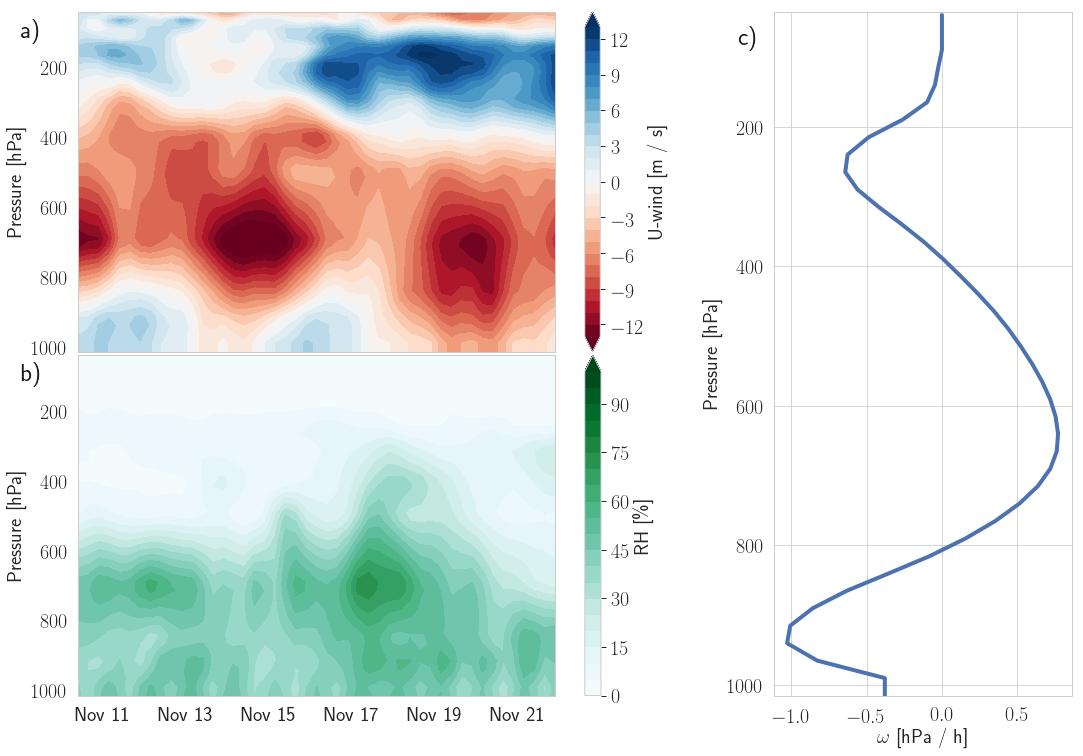

In [49]:
import matplotlib.dates as mdates
fig = plt.figure(figsize=(15,10))
rh = calc_rh(data_set['r']/1000, data_set['T'], data_set['lev'])
u_levels = np.arange(-13, 14)
rh_levels = np.arange(0, 105, 5)
for num, (data, levels, label, colm, extend) in enumerate(\
                                                  ((data_set['u'], u_levels, f'U-wind [{units.m/units.s}]', RdBu_11, 'both'), 
                                                  (100*rh, rh_levels, f'RH [\\{units.percent}]', BuGn_9, 'max'))):
    
    #ax = fig.add_subplot(2,1,num+1)
    ax = plt.subplot2grid((2, 10), (num, 0), colspan=6)
    T = pd.DatetimeIndex(data_set['time'].values).tz_localize(utc).tz_convert(timezone).tz_localize(None)
    X, Y = np.meshgrid(T[:-2], data_set['lev'])
    ax.invert_yaxis()
    #levels = np.arange(-vrange, vrange+1)
    im = ax.contourf(X, Y, data[:-2,:].T.values, levels, cmap=colm.mpl_colormap,
                    extend=extend)
    ax.tick_params(labelsize=20)
    cbar = fig.colorbar(im, extend='both')
    tmp = cbar.ax.tick_params(labelsize=20)
    tmp = cbar.set_label(label,size=20)
    myFmt = mdates.DateFormatter('%b %d')
    ax.set_ylabel(f'Pressure [{units.hPa}]', fontsize=20)
    if num == 1:
        _ = ax.xaxis.set_major_formatter(myFmt)
    else:
        _ = ax.xaxis.set_ticks([])
    ax.text(-0.12, 0.98, 'abc'[num]+')',
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,
        color='k', fontsize=25)

ax = plt.subplot2grid((2, 10), (0, 7), rowspan=2, colspan=6)
ax.plot(data_set['omega'][:].mean(axis=0), data_set['lev'], lw=4, color='b')
fig.subplots_adjust(bottom=0.04, top=0.99, right=0.99, left=0.07, wspace=0, hspace=0.01)
ax.tick_params(labelsize=20)
ax.set_ylabel(f'Pressure [{units.hPa}]', fontsize=20)
ax.set_xlabel(f'$\\omega$ [{units.hPa/units.hour}]', fontsize=20)
ax.set_ylim(35, 1015)
ax.text(-0.12, 0.98, 'c)',
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,
        color='k', fontsize=25)
ax.invert_yaxis()
fig.savefig(os.path.join(paper_path, 'Figure_02.pdf'), bbox_set_inches='tight', dpi=300)

In [351]:
units.hPa / units.hour

Unit("hPa / h")

In [46]:
ax.contourf?